出于解释的目的，我们在前几节内容里实现了简单的分词方法。这节会针对更先进的分词方法进行讲解，此分词方法基于一种叫做字节对编码（BPE）的概念。这节要讲的字节对编码分词器被用来训练大语言模型，诸如GPT-2，GPT3以及ChatGPT里使用的原始模型。  
因为实现BPE相对的复杂，所以我们将会使用已有的python开源库叫做[tiktoken](https://github.com/openai/tiktoken)。此开源库使用Rust非常高效的实现了BPE算法。与其他python库相同，我们可以从终端通过python的`pip`安装命令安装tiktoken库：

```shell
pip install tiktoken
```

此节代码是基于tiktoken 0.5.1来编写的，你可以使用如下代码来检验你目前安装的版本：

```python
from importlib.metadata import version
import tiktoken
print("tiktoken version:", version("tiktoken"))
```

当安装成功后，我们可以从tiktoken初始化BPE分词器，代码如下：

In [ ]:
tokenizer = tiktoken.get_encoding("gpt2")

这个分词器的使用和我们之前通过编码（encode）方法实现的`SimpleTokenizerV2`相似：

In [ ]:
text = "Hello, do you like tea? <|endoftext|> In the sunlit terraces of some"
integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
print(integers)

上面的代码会打印出如下的token IDs：

```text
[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 
```

我们然后可以使用解码方法将这些token IDs转化回文本，与我们之前使用的`SimpleTokenizerV2`相似：

In [ ]:
strings = tokenizer.decode(integers)
print(strings)

上面的代码会打印出如下内容：

```text
'Hello, do you like tea? <|endoftext|> In the sunlit terraces of 
```

基于上述的token IDs以及解码的文本，我们可以做出2点有价值的观察。第一，`<|endoftext|>`词元（token）被赋值了一个很大的token ID，例如，50256。事实上，被用于训练诸如GPT-2，GPT-3以及被ChatGPT使用的原始模型的BPE分词器，总计词汇的规模是50257，其中`<|endoftext|>`被指定为最大的token ID。  
第二，上述的BPE分词器可以正确的解码和编码没有见过的词汇，例如"someunknownPlace"。BPE解码器可以处理任何没有见过的词汇。那么，他是怎么无需使用`<|unk|>`词元就做到这个的呢？  
BPE使用的算法会将不在预定义词表里的单词分解为更小的子单词单元或者甚至是独立的字母，使BPE可以处理词表外的单词。所以，基于这种算法，如果分词器在分词时遇到了不熟悉的单词，他会使用一系列的子单词词元或者字母来替换它，就像图2.11阐述的那样。

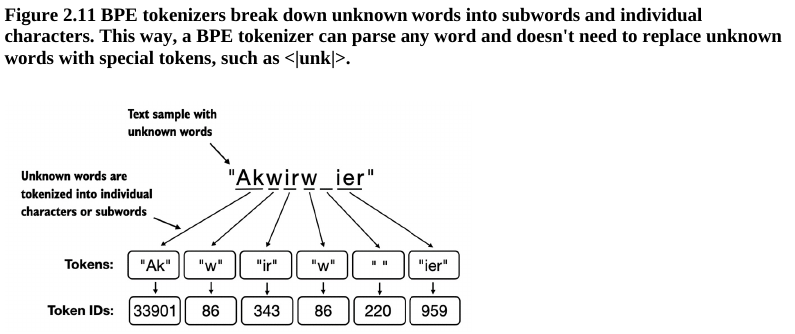

正如图2.11所示，将不认识的单词分解为更小的的词元或字母保证了分词器，以及后续被训练的大模型可以处理任意的文本，即使文本里包含了从来没在测试数据里出现过的单词。

**练习2.1 未知单词的字节对编码**  
尝试使用tiktoken库里的BPE分词器，对未知词汇"Akwirw ier"进行处理然后打印出一列词元编码（token IDs）。然后，针对这一列的每一个编码调用解码函数来重现图2.11所示的映射关系。最后，在词元ID序列上调用解码方法来确认是否它们可以重新构成原始的输入"Akwirw ier"。  
对BPE更详细的讨论和实现超出了本书的范围，但简短地说，它通过循环的将常用的字母组合成子单词，然后将常用的子单词再组合成单词来构建词汇库。例如，BPE开始于将所有独立的字母加入到他的词汇库。在下一个阶段，它将经常一起出现的字母组合合并成子单词。例如，"d"和"e"可能会被合并成子单词"de",这个子单词经常会出现在英语单词例如"define","depend", "made", 以及"hidden"。这种合并是由频率阈值决定的。